# Modelling

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, f1_score
from sklearn.metrics import roc_curve, auc
import shap


In [2]:
df = pd.read_csv('churn_cleaned_df.csv')
df.head()

,customerID,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,...,Contract_Two year,InternetService_DSL,InternetService_Fiber optic,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,tenure_outlier,MonthlyCharges_outlier,TotalCharges_outlier
0,7590-VHVEG,0,1,0,1.0,0,0,0,1,0,...,0,1,0,0,0,1,0,0,0,0
1,5575-GNVDE,0,0,0,34.0,1,0,1,0,1,...,0,1,0,0,0,0,1,0,0,0
2,3668-QPYBK,0,0,0,2.0,1,0,1,1,0,...,0,1,0,0,0,0,1,0,0,0
3,7795-CFOCW,0,0,0,45.0,0,0,1,0,1,...,0,1,0,1,0,0,0,0,0,0
4,9237-HQITU,0,0,0,2.0,1,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0


# Balancing our dataset
Given that our dataset is imbalanced (26.5% of the users churn), we need to correct this effect in order to obtain the desired results with the model.

SMOTE (Synthetic Minority Over-sampling Technique) is a popular algorithm used for data upsampling in machine learning. It creates synthetic samples of the minority class by creating new observations that are similar to existing observations, thus balancing the class distribution. We can perform data upsampling using SMOTE in Python with the imbalanced-learn library

In [3]:
# Drop the column and save it to a variable
#   If you need to bring the column back later, simply reassign it to the DataFrame
#   df['customerID'] = customer_id
customer_id = df.pop('customerID')

In [4]:
# Separate the target variable (Churn) from the rest of the dataset
X = df.drop('Churn', axis=1)
y = df['Churn']

# Split the data into training, validation, and testing sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val)

# Instantiate the SMOTE object
oversample = SMOTE()

# Apply SMOTE to upsample the minority class (Churn = 1) on the training set only
X_resampled_train, y_resampled_train = oversample.fit_resample(X_train, y_train)

# Combine the resampled features and target variable into a new training DataFrame
resampled_df_train = pd.concat([X_resampled_train, y_resampled_train], axis=1)

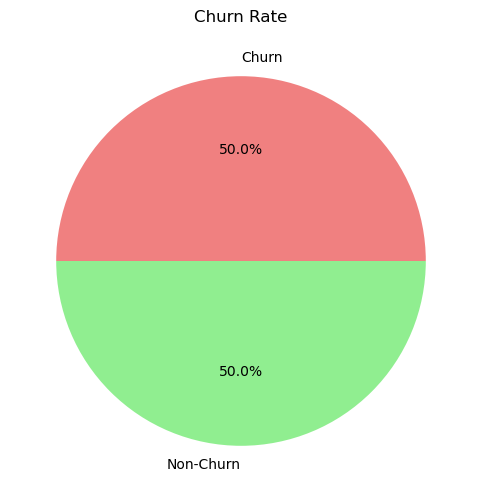

In [5]:
# Calculate the churn and non-churn counts
churn_count = resampled_df_train[resampled_df_train['Churn'] == 1].SeniorCitizen.count()
non_churn_count = resampled_df_train[resampled_df_train['Churn'] == 0].SeniorCitizen.count()

# Set up the plot size and title
plt.figure(figsize=(8, 6))
plt.title('Churn Rate')

# Set the colors for the pie chart sections
colors = ['lightcoral', 'lightgreen']

# Create the pie chart
plt.pie([churn_count, non_churn_count], labels=['Churn', 'Non-Churn'], autopct='%1.1f%%', colors=colors)

# Display the plot
plt.show()

In [6]:
# Initialize XGBoost classifier
model = xgb.XGBClassifier()

# Train the model on the resampled training set
model.fit(resampled_df_train.drop('Churn', axis=1), resampled_df_train['Churn'])

# Make predictions on the validation set
y_pred_val = model.predict(X_val)

# Calculate prediction probabilities on the validation set
y_prob_val = model.predict_proba(X_val)[:, 1] # Probability of the positive class (churn)

# Evaluate the model performance on the validation set
accuracy_val = accuracy_score(y_val, y_pred_val)
recall_val = recall_score(y_val, y_pred_val)
precision_val = precision_score(y_val, y_pred_val)
f1_val = f1_score(y_val, y_pred_val)
cm_val = confusion_matrix(y_val, y_pred_val)
tn_val, fp_val, fn_val, tp_val = cm_val.ravel()
specificity_val = tn_val / (tn_val + fp_val)

# Print evaluation metrics on the validation set
print("Validation Set Metrics:")
print(f"Accuracy: {accuracy_val:.4f}")
print(f"Recall: {recall_val:.4f}")
print(f"Precision: {precision_val:.4f}")
print(f"F1 Score: {f1_val:.4f}")
print(f"Confusion Matrix: \n{cm_val}")
print(f"Specificity: {specificity_val:.4f}")

# Make predictions on the test set
y_pred_test = model.predict(X_test)

# Calculate prediction probabilities on the test set
y_prob_test = model.predict_proba(X_test)[:, 1] # Probability of the positive class (churn)

# Evaluate the model performance on the test set
accuracy_test = accuracy_score(y_test, y_pred_test)
recall_test = recall_score(y_test, y_pred_test)
precision_test = precision_score(y_test, y_pred_test)
f1_test = f1_score(y_test, y_pred_test)
cm_test = confusion_matrix(y_test, y_pred_test)
tn_test, fp_test, fn_test, tp_test = cm_test.ravel()
specificity_test = tn_test / (tn_test + fp_test)

# Print evaluation metrics on the test set
print("\nTest Set Metrics:")
print(f"Accuracy: {accuracy_test:.4f}")
print(f"Recall: {recall_test:.4f}")
print(f"Precision: {precision_test:.4f}")
print(f"F1 Score: {f1_test:.4f}")
print(f"Confusion Matrix: \n{cm_test}")
print(f"Specificity: {specificity_test:.4f}")

Validation Set Metrics:
Accuracy: 0.7658
Recall: 0.5241
Precision: 0.5632
F1 Score: 0.5429
Confusion Matrix: 
[[883 152]
 [178 196]]
Specificity: 0.8531

Test Set Metrics:
Accuracy: 0.7807
Recall: 0.5481
Precision: 0.5942
F1 Score: 0.5702
Confusion Matrix: 
[[895 140]
 [169 205]]
Specificity: 0.8647


AUC: 0.8071


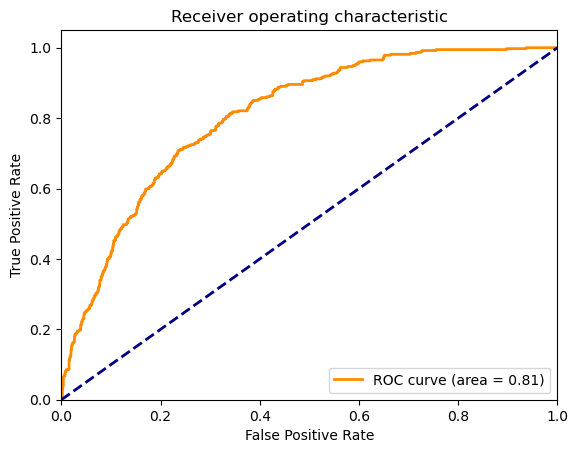

In [7]:
# Calculate the false positive rate (FPR), true positive rate (TPR), and threshold values for the ROC curve
fpr, tpr, thresholds = roc_curve(y_val, y_prob_val)

# Calculate the area under the ROC curve (AUC)
roc_auc = auc(fpr, tpr)

# Print the AUC score
print("AUC: {:.4f}".format(roc_auc))

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

Permutation explainer: 1410it [00:57, 20.84it/s]                          


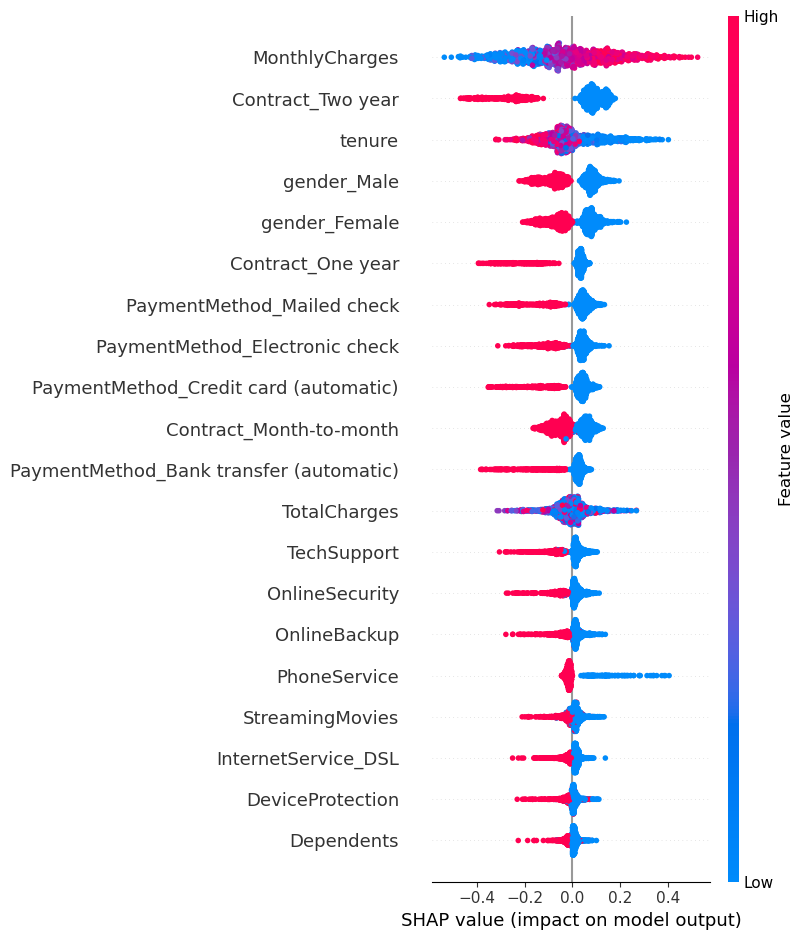

In [8]:
# Create SHAP values for the test set
explainer = shap.Explainer(model.predict, X_train)
shap_values = explainer(X_test)

# Create a summary plot
shap.summary_plot(shap_values, X_test)

MonthlyCharges being blue on the left and red on the right, it means that low values of MonthlyCharges have a negative impact on the predicted target value (i.e., lower probability of churn), whereas high values of MonthlyCharges have a positive impact (i.e., higher probability of churn).

Similarly, with tenure being blue on the right and red on the left, it means that low values of tenure have a positive impact on the predicted target value (i.e., higher probability of churn), whereas high values of tenure have a negative impact (i.e., lower probability of churn).

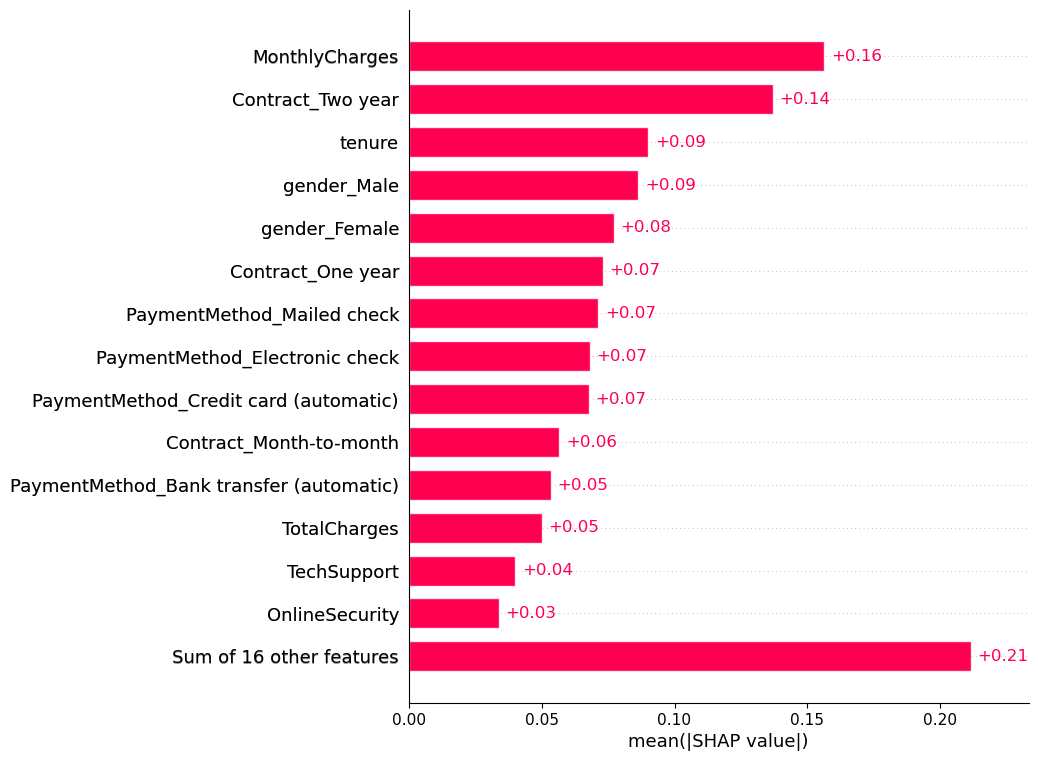

In [9]:
shap.plots.bar(shap_values, max_display=15)

In this case, the output shows that Contract_Two year is the most important feature, with a SHAP value of +0.16%. This means that changes in the Contract_Two year feature have the largest impact on the model's predictions. Specifically, This indicates that customers who are on a two-year contract are less likely to churn compared to those on a one-year or month-to-month contract.

The MonthlyCharges feature is the second most important feature with a SHAP value of +0.16% too. An increase in MonthlyCharges is associated with an increase in the likelihood of churn, while an decrease in MonthlyCharges is associated with a decrease in the likelihood of churn.

Overall, these results suggest that pricing plans, contract terms and how long are customers engaged with the company (tenure) are important factors in predicting customer churn. The model may be used to optimize pricing plans and contract terms to minimize churn and maximize customer retention.

In [10]:
# Forceplot for first observation
shap.initjs()
shap.plots.force(shap_values[38]) 

In [ ]:
# Plot the SHAP values
shap.plots.waterfall(shap_values[38])

In [ ]:
import pickle

# Assuming your trained model is named "xgb_model"
with open('model.pickle', 'wb') as f:
    pickle.dump(model, f)

In [ ]:
with open('model.pickle', 'rb') as f:
    xgb_model = pickle.load(f)

In [ ]:
df = pd.read_csv('churn_cleaned_df.csv')
df

df[df['Churn']==1]

df.iloc[2]